This tutorial deals with __reading a SEG-Y data set__ in various different ways and analyzing the available data. Please make sure you have downloaded the test data as outlined in the file "examples/data/README".

Let's start by importing some packages (including the __seisio__ package itself) and setting up the logging config.

In [1]:
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import sys
sys.path.insert(1, '../')

In [2]:
import seisio

In [3]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s', force=True)
log = logging.getLogger("main")

We would like to read the file called Line_001.sgy in the data directory. So let's just try the following:

In [4]:
infile = "data/Line_001.sgy"
sio = seisio.input(infile)

INFO: Input file: data/Line_001.sgy
INFO: SEG-Y textual file header encoding looks to be 'EBCDIC' (best guess).
INFO: Input file endianess looks to be '>' (best guess).
INFO: SEG-Y revision: original SEG-Y conforming to 1975 standard.
INFO: Data sample format: 4-byte IBM floating-point.
INFO: Number of additional textual header records: 0.
INFO: Number of trailer stanza records: 0.
INFO: SEG-Y trace header extension 1 is not present.
INFO: Number of user-defined trace headers: 0
INFO: Byte offset of first trace relative to start of file: 3600 bytes.
INFO: Number of samples per data trace: 1501.
INFO: Sampling interval: 2000 (unit as per SEG-Y standard).
INFO: Number of data traces in file: 71284.
INFO: Delay (on first trace): 0 (unit as per SEG-Y standard).


The standard INFO output already provides quite a lot of information about the file. Apparently, there are 71284 traces, each trace has 1501 samples, and the sampling interval is 2 milliseconds as per SEG-Y standard. The data themselves are stored as 4-byte (32-bit) IBM floating-point values. The endianess of the file and the encoding of the primary SEG-Y textual header have been detected automatically. The same holds for the number of additional header records, the presence of header extension 1, the number of user-defined trace headers, and the number of trailer records. As expected with SEG-Y rev. 0, none of these features are present here as they aren't allowed by the original SEG-Y standard from 1975. There are options available to override the automatic detections if necessary in case of any problems. Default binary and trace header definition tables have been used, but a user could also provide own definition tables (in JSON format) in case the data had an unusual header layout or we wanted to rename/remap certain headers or pick up additional header words (mnemonics) from certain byte locations.

Note: The file is not kept open all the time, i.e., we do not need a context manager here to clean up in case something goes wrong. The file is opened only when an I/O operation needs to take place.

As soon as the seisio object is established, we can get certain properties:

In [5]:
file_endianess = sio.endianess       # file endianess, little or big endian
file_name = sio.file                 # file name
file_size = sio.fsize                # file size in bytes
trace_header_size = sio.thsize       # size in bytes of a single trace header
trace_header_keys = sio.mnemonics    # list of trace header mnemonics
trace_size = sio.trsize              # size in bytes of a single complete trace
nsamples = sio.nsamples              # number of samples per trace; or sio.ns for short
ntraces = sio.ntraces                # total number of traces in file; or sio.nt for short
sampling_interval = sio.vsi          # sampling interval (usually in microsec) along vertical axis
sampling_times = sio.vaxis           # vector of sampling times (vertical axis)
recording_delay = sio.delay          # delay recording time of first trace (usually in millisec)
ntxtrecord = sio.ntxtrec             # number of additional textual header records
ntxtrailer = sio.ntxtrail            # number of textual trailer records
nthuser = sio.nthuser                # number of user-defined trace headers
trace_header_ext1 = sio.thext1       # flag whether trace header extension 1 is present
textual_file_header = sio.txthead    # primary SEG-Y textual file header (decoded if necessary)
binary_file_header = sio.binhead     # SEG-Y binary file header

We can get and log the content of the primary SEG-Y textual header at the same time:

In [6]:
txthead = sio.log_txthead()

INFO: SEG-Y textual file header:
INFO: -------- BEGIN --------
C 1 CLIENT                        COMPANY                       CREW NO         
C 2 LINE:  LINE_001           AREA                        MAP ID                
C 3 REEL NO           DAY-START OF REEL     YEAR      OBSERVER                  
C 4 INSTRUMENT: MFG            MODEL            SERIAL NO                       
C 5 DATA TRACES/RECORD: 282  AUXILIARY TRACES/RECORD:  2    CDP FOLD            
C 6 SAMPLE INTERNAL:  4MS     SAMPLES/TRACE: 750  BITS/IN      BYTES/SAMPLE 4   
C 7 RECORDING FORMAT        FORMAT THIS REEL: SEGY   MEASUREMENT SYSTEM         
C 8 SAMPLE CODE: FLOATING PT     FIXED PT     FIXED PT-GAIN     CORRELATED      
C 9 GAIN  TYPE: FIXED     BINARY     FLOATING POINT     OTHER                   
C10 FILTERS: ALIAS     HZ  NOTCH     HZ  BAND    -     HZ  SLOPE    -    DB/OCT 
C11 SOURCE: TYPE            NUMBER/POINT        POINT INTERVAL                  
C12     PATTERN:                           LEN

Obviously, whoever created this SEG-Y file didn't put a lot of information in the primary textual header (EBCDIC), and some of the information is even wrong (such as the sampling interval). Unfortunately, that's fairly common when dealing with SEG-Y data.

We can also get and log the binary file header at the same time. When logging such a header, it is default to not print entries with value zero. In other words, the list here only shows binary header entries with non-zero values:

In [7]:
binhead = sio.log_binhead()

INFO: SEG-Y binary file header:
+--------+---------+----------------------------------------------------------+
|        |   value | description                                              |
|--------+---------+----------------------------------------------------------|
| nt     |   34463 | Number of traces per ensemble                            |
| dt     |    2000 | Sample interval                                          |
| dtorig |    2000 | Sample interval of original field recording              |
| ns     |    1501 | Number of samples per trace                              |
| nsorig |    8193 | Number of samples per trace for original field recording |
| format |       1 | Data sample format code                                  |
| tsort  |       1 | Trace sorting code                                       |
| msys   |       1 | Measurement system                                       |
+--------+---------+----------------------------------------------------------+


Let's read all the treace headers from disk so we can have a look at them more closely. There are other methods available to only read certain subsets of trace headers. However, here we just read all of the in one go:

In [8]:
trace_headers = sio.read_all_headers()

INFO: Reading all 71284 trace headers from disk...
INFO: Reading all headers took 0.055 seconds.


Now we can determine some trace header statistics to get a good overview of the data set at hand. As we have already read the trace headers from disk, we can make those headers available to the *log_thstat()* method, otherwise the method would read the trace headers from disk itself.

In [9]:
thstat = sio.log_thstat(traces=trace_headers)

INFO: Calculating trace header statistics.
INFO: Summary of trace header statistics (zeros excluded):
+--------+--------+--------+---------------+---------------+-----------+-----------+
|        |    min |    max |          mean |           std |       25% |       75% |
|--------+--------+--------+---------------+---------------+-----------+-----------|
| tracl  |      1 |  71284 |  35642.5      | 20578.1       |  17821.8  |  53463.2  |
| tracr  |      1 |  71284 |  35642.5      | 20578.1       |  17821.8  |  53463.2  |
| fldr   |    231 |    481 |    356        |    72.4574    |    293    |    419    |
| tracf  |     -1 |    282 |    140.496    |    81.9899    |     69.75 |    211.25 |
| ep     |     32 |    282 |    157        |    72.4574    |     94    |    220    |
| cdpt   |      1 |    284 |    142.5      |    81.9838    |     71.75 |    213.25 |
| trid   |      0 |      1 |      0.992958 |     0.0836227 |      1    |      1    |
| nhs    |      1 |      1 |      1        |    

Similar to logging the binary file header, only trace header mnemonics whose values aren't all zero are shown here to keep the list reasonably short. The output here is somewhat similar to the SU command *surange* but does not only show the minimum and maximum value but also other statistics.

You might wonder what trace header mnemonics are available in the first place. We can easily query and log the (in this case standard) trace header definition setup:

In [10]:
sio.log_thdef()

INFO: Trace header definition:
+------------+--------+--------+------------------------------------------------------------------+
|            |   byte | type   | description                                                      |
|------------+--------+--------+------------------------------------------------------------------|
| tracl      |      0 | i      | Trace sequence number within line                                |
| tracr      |      4 | i      | Trace sequence number within file                                |
| fldr       |      8 | i      | Original field record number                                     |
| tracf      |     12 | i      | Trace number within original field record                        |
| ep         |     16 | i      | Energy source point number                                       |
| cdp        |     20 | i      | Ensemble number                                                  |
| cdpt       |     24 | i      | Trace number within ensemble        

Now let's read some data and explore the various ways this can be done. First, we simply read the entire data set into memory:

In [11]:
dataset = sio.read_all_traces()

INFO: Reading entire file (71284 traces) from disk...
INFO: Reading all traces took 0.1 seconds.
INFO: Converting IBM floats to IEEE floats.
INFO: Converting all traces took 0.4 seconds.


Note: All read-functions convert the data from IBM floats to IEEE floats while keeping the original endianess. The data set could easily be swapped using `dataset.view(dataset.dtype.newbyteorder()).byteswap()`. The information about the types of the various trace header mnemonics is readily available (see `dataset.dtype`).

Accessing indiviual trace headers for all traces just read from disk is as simple as:

In [12]:
fldr = dataset["fldr"]

Just as simple is setting trace headers. This can be done by providing a vector of length `ntraces` with the values to be used, or we can provide a scalar value which will then be used for all the traces. We can also use other trace header mnemonics and perform some maths:

In [13]:
log.info("Setting a variable offset using an array.")
dataset["offset"] = range(ntraces)
log.info("Offsets now: %s", dataset["offset"])
log.info("Setting a constant offset using a scalar.")
dataset["offset"] = 0
log.info("Offsets now: %s", dataset["offset"])
log.info("Setting 'ep' as twice 'fldr'.")
dataset["ep"] = 2 * dataset["fldr"] 
log.info("'fldr': %s", dataset["fldr"])
log.info("'ep': %s", dataset["ep"])

INFO: Setting a variable offset using an array.
INFO: Offsets now: [    0     1     2 ... 71281 71282 71283]
INFO: Setting a constant offset using a scalar.
INFO: Offsets now: [0 0 0 ... 0 0 0]
INFO: Setting 'ep' as twice 'fldr'.
INFO: 'fldr': [231 231 231 ... 481 481 481]
INFO: 'ep': [462 462 462 ... 962 962 962]


We can also filter the data based on trace header mnemonics. In this example, we only keep traces whose `trid` trace header mnemonic is greater than zero:

In [14]:
data_live = dataset[dataset["trid"] > 0]
log.info("Length of data set: original = %d, filtered = %d", len(dataset), len(data_live))

INFO: Length of data set: original = 71284, filtered = 70782


We can also add a new trace header mnemonic to our data set. Let's create a rather unusual header mnemonic of type 'bool' and initialize it to 'True' for the entire data set:

In [15]:
data_live_updated = seisio.tools.add_mnemonic(data_live, names="myheader", data=True, dtypes=bool)
log.info("First / last 'myheader' value: %s / %s", data_live_updated["myheader"][0], data_live_updated["myheader"][-1])

INFO: First / last 'myheader' value: True / True


The actual seismic data are stored under the `data` mnemonic. When you access it, you get a 2D Numpy array of shape `(ntraces, nsamples)`:

In [16]:
seis = dataset["data"]
log.info("Shape of seismic data array: %s", seis.shape)

INFO: Shape of seismic data array: (71284, 1501)


Instead of reading the whole data set, we can read individual trace numbers. The trace numbers are zero-based. Let's read five specific traces and cross-check what we've read by comparing the `tracl` header mnemonic values (one-based) with the traces we requested to read. If we subtract one from the header `tracl`, the numbers should agree:

In [17]:
traces_to_read = [0, ntraces//4, ntraces//2, 3*ntraces//4, ntraces-1]
log.info("Traces to read: %s", traces_to_read)
traces = sio.read_traces(*traces_to_read)
log.info("Trace numbers we just read: %s", traces["tracl"]-1)

INFO: Traces to read: [0, 17821, 35642, 53463, 71283]
INFO: Reading 5 specific trace(s) from disk...
INFO: Trace numbers we just read: [    0 17821 35642 53463 71283]


Using the *read_batch_of_traces()* method we can read consecutive traces starting from a particular position in the file. In this example, let's read 200 traces starting at trace 99 (the 100th trace in the file). If we again check the `tracl` header mnemonic afterwards, we would expect the first trace to have a value of 100, and the last trace to have a value of 299:

In [18]:
traces_batch = sio.read_batch_of_traces(start=99, ntraces=200)
log.info("First / last 'tracl' value: %d / %d", traces_batch["tracl"][0], traces_batch["tracl"][-1])

INFO: Reading 200 trace(s) from disk starting at trace 99...
INFO: First / last 'tracl' value: 100 / 299


We can read multiple blocks of consecutive traces, for instance four blocks of two traces each, starting at trace 0, with a stride of 1000 traces (between the beginnings of each block). Again, we log the `tracl` header mnemonic afterwards to check that we have indeed read the correct traces that were requested:

In [19]:
traces_mbatch = sio.read_multibatch_of_traces(start=0, block=2, stride=1000, count=4)
log.info("'tracl' headers: %s", traces_mbatch["tracl"])

INFO: Reading 4 block(s) of 2 trace(s) from disk, starting at 0 with stride 1000...
INFO: 'tracl' headers: [   1    2 1001 1002 2001 2002 3001 3002]


One of the simplest ways to just loop through the file and reading a constant number of traces at the time is the *batches()* method that yields a subset of the data each time:

In [20]:
for i, tr in enumerate(sio.batches(batch_size=10000)):
    log.info("Batch #%d, number of traces: %d", i, len(tr))

INFO: Reading 10000 trace(s) from disk starting at trace 0...
INFO: Batch #0, number of traces: 10000
INFO: Reading 10000 trace(s) from disk starting at trace 10000...
INFO: Batch #1, number of traces: 10000
INFO: Reading 10000 trace(s) from disk starting at trace 20000...
INFO: Batch #2, number of traces: 10000
INFO: Reading 10000 trace(s) from disk starting at trace 30000...
INFO: Batch #3, number of traces: 10000
INFO: Reading 10000 trace(s) from disk starting at trace 40000...
INFO: Batch #4, number of traces: 10000
INFO: Reading 10000 trace(s) from disk starting at trace 50000...
INFO: Batch #5, number of traces: 10000
INFO: Reading 10000 trace(s) from disk starting at trace 60000...
INFO: Batch #6, number of traces: 10000
INFO: Reading 1284 trace(s) from disk starting at trace 70000...
INFO: Batch #7, number of traces: 1284


The last batch of traces is obviously smaller than the requested batch size as there weren't enough traces left in the file to provide 10,000 traces.

We can also loop through the file one trace at the time but keep in mind that this isn't very efficient. Here, we log the `tracl` header mnemonic every 10,000th trace:

In [21]:
for i, tr in enumerate(sio.traces(silent=True)):
    if i % 10000 == 0:
        log.info("Trace #%d, header 'tracl': %d", i, tr["tracl"])

INFO: Trace #0, header 'tracl': 1
INFO: Trace #10000, header 'tracl': 10001
INFO: Trace #20000, header 'tracl': 20001
INFO: Trace #30000, header 'tracl': 30001
INFO: Trace #40000, header 'tracl': 40001
INFO: Trace #50000, header 'tracl': 50001
INFO: Trace #60000, header 'tracl': 60001
INFO: Trace #70000, header 'tracl': 70001


In particular with prestack data we would probably like to read the data as ensembles (traces that share a certain header mnemonic value). To do so, we have to create a lookup index. We can use a filter function to remove traces with `trid` header values of 0 ('unknown' traces). Let's group ensembles by `fldr` (field records, i.e., shots) and sort the traces within each ensemble by header mnemonic `tracf` (trace number within field record) in descending order:

In [22]:
sio.create_index(headers=trace_headers, group_by="fldr", sort_by="tracf", sort_order="<", filt=(lambda x: x['trid'] > 0))

INFO: Ensemble lookup index has filter applied.
INFO: Created lookup index for [np.str_('fldr')] (order '>').
INFO: Each ensemble is sorted by [np.str_('tracf')] (order '<').
INFO: Number of ensembles: 251


There are 251 ensembles (once the filter function is applied). We can now get various properties related to the ensembles:

In [23]:
nensembles = sio.nensembles        # number of ensembles, or sio.ne for short
ntraces_per_ensemble = sio.nte     # vector containing number of traces per ensemble
max_ntraces = sio.maxnte           # size (no. of traces) of largest ensemble
ensemble_keys = sio.ensemble_keys  # keys to identify the different ensembles
log.info("Maximum number of traces within all the ensembles: %d", max_ntraces)

INFO: Maximum number of traces within all the ensembles: 282


Apparently, the largest ensemble has 282 traces. We could now loop through the ensembles ourselves using the ensemble keys (see above), but it is much more convenient to use the following way which will provide us with one ensemble at the time in the order we requested when creating the index:

In [24]:
for i, ens in enumerate(sio.ensembles(silent=True)):
    if i % 50 == 0:
        log.info("Ensemble #%d, 'fldr' %d, first / last 'tracf' value: %d / %d", i, ens["fldr"][0], ens["tracf"][0], ens["tracf"][-1])

INFO: Ensemble #0, 'fldr' 231, first / last 'tracf' value: 282 / 1
INFO: Ensemble #50, 'fldr' 281, first / last 'tracf' value: 282 / 1
INFO: Ensemble #100, 'fldr' 331, first / last 'tracf' value: 282 / 1
INFO: Ensemble #150, 'fldr' 381, first / last 'tracf' value: 282 / 1
INFO: Ensemble #200, 'fldr' 431, first / last 'tracf' value: 282 / 1
INFO: Ensemble #250, 'fldr' 481, first / last 'tracf' value: 282 / 1


As can be seen, the ensembles start at the smallest `fldr` (shot number) and increase, while the traces within each ensemble are sorted by decreasing `tracf` header mnemonic, as requested. We could also use more than one trace header menmonic to group the data, or more than one trace header mnemonic to sort the data.

As final part of this tutorial, let's create a simple plot of the last ensemble we have just read:

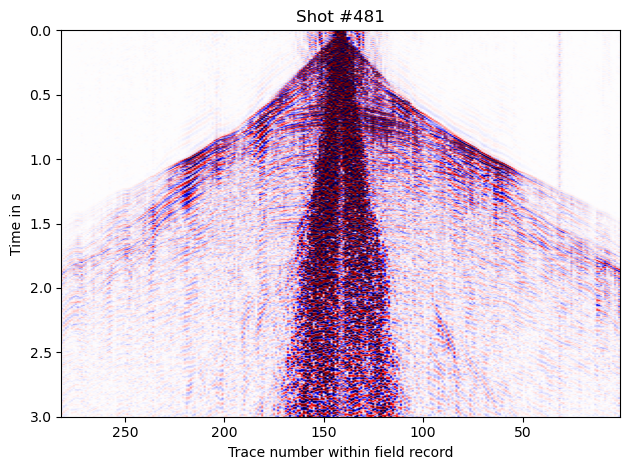

In [25]:
fig, ax = plt.subplots(1, 1)
data = ens["data"]
vmm = np.percentile(data, 97.0)
norm = cm.colors.Normalize(vmax=vmm, vmin=-vmm)
ax.imshow(data.T, cmap="seismic", origin="upper", aspect="auto", norm=norm,
          extent=[ens["tracf"][0], ens["tracf"][-1], sampling_times[-1], sampling_times[0]])
ax.set_title(f"Shot #{ens['fldr'][0]}")
ax.set_xlabel("Trace number within field record")
ax.set_ylabel("Time in s")
plt.tight_layout()
plt.show()

That's it for now.

Note: We provide a Python package called __seisplot__ to provide a convenient way to display seismic data as image or wiggle plots.